In [1]:
import os
import sys

# Add Election Package to Path
ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-1]) 
sys.path.append(ROOT_DIR)

from typing import Dict, Tuple, Optional, Set
import psycopg2 
import json
from functools import reduce
from collections import defaultdict as ddict, namedtuple
import itertools
import pandas as pd
from pandas import DataFrame as DF, Series
import numpy as np
import networkx as nx
from networkx.algorithms import approximation as nxalg
from networkx.algorithms.components import connected as nxconn
import networkx.algorithms.centrality as nxcent
import pygraphviz as pgv
from fuzzywuzzy import process
from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

/Users/ggemelos/anaconda3/envs/elections2018/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
RESOURCE_DIR = os.path.join(ROOT_DIR, 'not_for_git')
LOGIN_FILE = os.path.join(RESOURCE_DIR, 'elections_login.json')
DATA_PATH = os.path.join(ROOT_DIR, 'cleaned_data', 'cleaned_data')

In [3]:
def get_db_login_info():
    with open(LOGIN_FILE, 'r') as f:
        login_info = json.load(f)
    return login_info
    
def connect_to_db():
    login_info = get_db_login_info()
    return psycopg2.connect(host=login_info['ip'],
                            dbname=login_info['db'],
                            user=login_info['username'],
                            password=login_info['password'])

In [4]:
# List all available tables
conn = connect_to_db()
cursor = conn.cursor()
cursor.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
tables = [x[0] for x in cursor.fetchall()]
conn.close()
tables

['transaction_details',
 'committees_list',
 'ballots',
 'committee_history',
 'donor',
 'election_activity',
 'payee',
 'statement_of_org',
 'transactions']

In [5]:
def fetch_candidates() -> pd.DataFrame:
    return pd.read_csv(os.path.join(ROOT_DIR, 'misc_data', 'candidates.csv'), 
                       header=None, 
                       names=["name", "count"])

def fetch_state_org() -> pd.DataFrame:
    conn = connect_to_db()
    state_org = pd.read_sql("SELECT * FROM statement_of_org", conn)
    conn.close() 
#     state_org = pd.read_csv(os.path.join(DATA_PATH, 'statement_cleaned.csv'), low_memory=False)

    state_org['committee_id'] = state_org['committee_id'].apply(str)
    state_org['committee_name'] = state_org['committee_name'].apply(str)
    return state_org

def fetch_transaction() -> pd.DataFrame:
    conn = connect_to_db()
    trans = pd.read_sql("SELECT * FROM transactions", conn)
    conn.close()
#     trans = pd.read_csv(os.path.join(DATA_PATH, 'transactions_cleaned.csv'))

    trans['committee_id'] = trans['committee_id'].apply(str)
    trans['contributor_payee'] = trans['contributor_payee'].apply(str)
    
    # Map all payees to committee ids 
    state_org = fetch_state_org()
    committee_id_lookup = {id:name for name, id in zip(state_org['committee_name'].values, state_org['committee_id'].values)}
    trans['contributor_payee'] = trans['contributor_payee'].apply(lambda x: committee_id_lookup[x] if x in committee_id_lookup else x)
    trans['committee_id'] = trans['committee_id'].apply(lambda x: committee_id_lookup[x] if x in committee_id_lookup else x)
    
    return trans 

def calc_icdf(x, counts, values) -> np.ndarray:
    values = np.array(values)
    counts = np.array(counts)
    
    index = np.argsort(values)
    
    values = values[index]
    norm_counts = counts / np.sum(counts)
    norm_counts = norm_counts[index]
    
    
    return np.interp(x=x, 
                     xp=np.cumsum(norm_counts), 
                     fp=values)

In [6]:
# Load data
trans = fetch_transaction()
state_org = fetch_state_org()

In [7]:
'''
Fuzzy Matching of Committees
FIXME: Need to come back to this
''' 
class CommitteMatch(object):
    def __init__(self, login_info, candidates):
        self._db_login = login_info
        self.candidates = fetch_candidates()
        
    def get_committee_matches(self, committee, top_n):
        return process.extract(committee, self.candidates, limit=top_n)

In [8]:
class DirectedGraph(object):
    '''
    Class for Graphical Analysis of Transactions
    '''
    def __init__(self, edges: Dict[Tuple[str, str], float]):
        sources, sinks = zip(*edges.keys())
        
        # Relabel Nodes with Ints
        node_names = set(sources + sinks)
        self.__name_lookup = {node_id: node_name for node_id, node_name in enumerate(node_names)}
        self.__id_lookup = {node_name: node_id for node_id, node_name in self.__name_lookup.items()}
        edges = {(self.__id_lookup[epoints[0]], self.__id_lookup[epoints[1]]): val for epoints, val in edges.items()}
        
        sources, sinks = zip(*edges.keys())
        self.sources = np.unique(np.array(sources))
        self.sinks = np.unique(np.array(sinks))
        self.nodes = np.unique(np.hstack((self.sources, self.sinks)))
        
        # Create Graph 
        self.graph = nx.DiGraph()
        self.graph.add_weighted_edges_from([(nodes[0], nodes[1], strength) for nodes, strength in edges.items()])
        
        # Get degree statistics
        self.degrees_in = ddict(lambda: 0)
        self.degrees_out = ddict(lambda: 0)
        for node in self.nodes:
            self.degrees_in[self.graph.in_degree(node)] += 1
            self.degrees_out[self.graph.out_degree(node)] += 1
            
        # Get degree statistics
        print('Number of nodes: {:,.0f}'.format(self.graph.number_of_nodes()))
        print('Number of edges: {:,.0f}'.format(self.graph.number_of_edges()))
     
    @staticmethod
    def build_from_transaction(transactions: pd.DataFrame, total_donation_threshold=0, donation_threshold=0):
        '''
        Contructs a graph from dataframe of transactions
        
        :param transactions: Transaction data as returned by fetch_transaction
        :param total_donation_threshold: Minimum total amount per edge, sum of all donation between to parties (default: 0)
        :param donation_threshold: Minimum amount per donation (default: 0)
        :return: Graph
        '''
        payments = ddict(list)
        for sink, source, amount in transactions[['committee_id', 'contributor_payee', 'amount']].values:
            if abs(amount) < donation_threshold:
                continue
            if amount > 0:
                payments[(source, sink)].append(amount)
            else:
                payments[(sink, source)].append(-amount)

        edges = {key: sum(amount) for key, amount in payments.items() if sum(amount) >= total_donation_threshold}    
        
        graph = DirectedGraph(edges)
        
        # Print Stats
        percentiles = np.array([0, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])
        
        degrees, counts = zip(*graph.degrees_out.items())
        prct_out = calc_icdf(percentiles, counts, degrees)

        degrees, counts = zip(*graph.degrees_in.items())
        prct_in = calc_icdf(percentiles, counts, degrees)



        total_donation_amount = np.array([amt for amt in edges.values()])
        donation_amount = np.abs(transactions['amount'])
        donation_amount = donation_amount[donation_amount >= DONATION_THRESHOLD]
        data = np.vstack((np.nanpercentile(total_donation_amount, percentiles * 100),
                          np.nanpercentile(donation_amount, percentiles * 100),
                          prct_in, 
                          prct_out)).T


        df = pd.DataFrame(data=data, 
                          columns=['Total Donation Amt', 'Per Donation Amt', 'In Bound Degree', 'Out Bound Degree'], 
                          index=['{:,.2%}'.format(pp) for pp in percentiles])
        df['Total Donation Amt'] = df['Total Donation Amt'].apply(lambda x: '${:,.0f}'.format(x))
        df['Per Donation Amt'] = df['Per Donation Amt'].apply(lambda x: '${:,.0f}'.format(x))
        
        display(df)
        
        return graph
        
    @property
    def undirected_graph(self) -> nx.Graph:
        '''
        An undirected graph
        '''
        return self.graph.to_undirected()
        
    def get_node_name(self, node_id: int) -> str:
        '''
        Node graph id to node name lookup
        '''
        return self.__name_lookup[node_id]
    
    def get_node_id(self, node_name: str) -> int:
        '''
        Node name to node graph id lookup
        '''
        return self.__id_lookup[node_name]
    
    def get_neighborhood(self, node_name=None, node_id=None, distance: int=1, valid_bridging_node_ids: Optional[Set[int]]=None) -> nx.DiGraph:
        '''
        Find the subgraph consiting off all nodes a set distance from the specified node.  Can specify the
        set of nodes which can be tranversed/used to bridge, e.g. can choose to only bridge on nodes representing
        committees.  None commite nodes can appear in teh resulting subgraph, but can not used to connect to otherwise
        unconnected subgraphs
        
        :param node_name: Name of node in desired subgraph (can specify name or id)
        :param node_id: Id of node in desired subgraph (can specify name or id)
        :param distance: Max distance from specified node to include in subgraph (default: 1)
        :param valid_bridging_nodes: Set of node ids to which can be traversed, the connecting nodes.  The set must be 
                                     the node ids and not the node names. If not specified, all conected node will be 
                                     transerved.
        '''

        def get_node_list(graph, node_id, distance):
            if distance == 1:
                if valid_bridging_node_ids is None or node_id in valid_bridging_node_ids:
                    return list(graph.adj[node_id]) + [node_id]
                else:
                    return [node_id]
            else:
                neighborhood = get_node_list(graph, node_id, 1)
                return list(set(reduce(lambda x, y: x + y, (get_node_list(graph, neigh, distance-1) for neigh in neighborhood), [])))
        
        node_id = node_id if node_id is not None else self.get_node_id(node_name)
        
        return self.graph.subgraph(get_node_list(self.undirected_graph, node_id, distance))

        

In [9]:
# Create Graph Components
DONATION_THRESHOLD = 1000
TOTAL_DONATION_THRESHOLD = 10000

graph = DirectedGraph.build_from_transaction(transactions=trans, 
                                             donation_threshold=DONATION_THRESHOLD,
                                             total_donation_threshold=TOTAL_DONATION_THRESHOLD)

Number of nodes: 5,343
Number of edges: 9,160


,Total Donation Amt,Per Donation Amt,In Bound Degree,Out Bound Degree
0.00%,"$10,000","$1,000",0.000000,0.000000
25.00%,"$12,519","$1,000",0.000000,0.201881
50.00%,"$20,000","$2,000",0.000000,0.563481
75.00%,"$43,209","$4,125",0.000000,0.925081
90.00%,"$114,610","$10,000",0.508633,2.197449
95.00%,"$225,733","$16,853",5.384783,4.323469
99.00%,"$922,145","$59,482",37.285000,16.190000
99.90%,"$5,475,108","$350,000",204.106000,48.942000
99.99%,"$20,534,752","$1,872,650",326.573900,90.054100


In [10]:
# Calculate connected components
conn_comp = sorted(nxconn.connected_component_subgraphs(graph.undirected_graph), 
                   key=lambda g: g.number_of_nodes(), 
                   reverse=True)
ccsizes = sorted([ccomp.number_of_nodes() for ccomp in conn_comp], reverse=True)
print('\nTop 10 comp: ' + ', '.join(('{:,.0f}'.format(ccsize) for ccsize in ccsizes[:10])))


Top 10 comp: 5,034, 7, 7, 7, 7, 6, 6, 6, 5, 5


Neighborhoods with and without bridging on sources


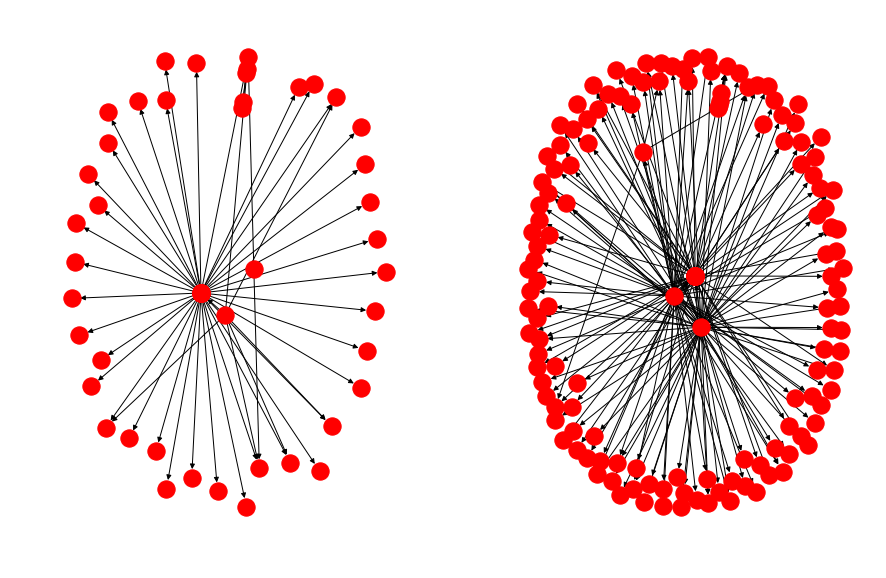

In [11]:
# Plot Neighborhood
node_name = 'Wayne Krieger for State Representative'
nghd_wo_source_bridge = graph.get_neighborhood(node_name=node_name, 
                                               distance=2, 
                                               valid_bridging_node_ids=set(graph.sinks))
nghd_w_source_bridge = graph.get_neighborhood(node_name=node_name, 
                                              distance=2)
plt.figure(figsize=(15, 10))
plt.subplot(121)
nx.draw(nghd_wo_source_bridge, font_weight='bold')

plt.subplot(122)
nx.draw(nghd_w_source_bridge, font_weight='bold')
print('Neighborhoods with and without bridging on sources')

In [ ]:
# BETWEENESS
degree = graph.undirected_graph.degree
sorted(((x, graph.get_node_name(x), degree[x], y) for x, y in nxcent.betweenness_centrality(graph.graph).items()), key=lambda x: x[3], reverse=True))

In [ ]:
# EIGENVECTOR
degree = graph.undirected_graph.degree
sorted(((x, graph.get_node_name(x), degree[x], y) for x, y in nxcent.eigenvector_centrality(graph.graph).items()), key=lambda x: x[3], reverse=True)

In [ ]:
# CLOSENESS
degree = graph.undirected_graph.degree
sorted(((x, graph.get_node_name(x), degree[x], y) for x, y in nxcent.closeness_centrality(graph.graph).items()), key=lambda x: x[3], reverse=True)